In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import os
import pandas as pd
folder_path = "/content/drive/MyDrive/Original_Dataset"

In [80]:
import os
print(os.listdir("/content/drive/MyDrive"))

['Colab Notebooks', 'exhibition videos', 'af video.mp4', 'data.zip', 'CODELOOM (File responses)', 'CODELOOM (Responses).gsheet', 'CODELOOM.gform', 'dataset', 'Split Dataset', 'model_checkpoint.weights.h5', 'final_model.h5', 'Original_Dataset.zip']


In [81]:
import zipfile

zip_path = "/content/drive/MyDrive/Original_Dataset.zip"
extract_path = "/content/Original_Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [82]:
import random
import shutil
from tqdm import tqdm

def split_dataset(original_dir, output_dir, train_pct=0.7, test_pct=0.2, val_pct=0.1, seed=42):
    assert abs(train_pct + test_pct + val_pct - 1.0) < 1e-6, "Splits must sum to 1.0"

    random.seed(seed)

    for class_name in os.listdir(original_dir):
        class_path = os.path.join(original_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        images = [img for img in images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        total = len(images)
        train_end = int(total * train_pct)
        test_end = train_end + int(total * test_pct)

        split_points = {
            'train': images[:train_end],
            'test': images[train_end:test_end],
            'val': images[test_end:]
        }

        for split, split_images in split_points.items():
            out_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(out_class_dir, exist_ok=True)

            for img in tqdm(split_images, desc=f"Copying {split}/{class_name}"):
                src = os.path.join(class_path, img)
                dst = os.path.join(out_class_dir, img)
                shutil.copy2(src, dst)


In [83]:
split_dataset(
    original_dir="/content/Original_Dataset/Original Dataset",
    output_dir="split_dataset",
    train_pct=0.7,
    test_pct=0.2,
    val_pct=0.1
)

Copying val/WheatBlast: 100%|██████████| 40/40 [00:00<00:00, 274.18it/s]


In [84]:
# AUGMENTATION OF TRAIN SET
import tensorflow as tf
from tensorflow.keras import layers

# Image dimensions and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# augmentation layer
data_augmentation = tf.keras.Sequential([
    # 1. Geometric Transformations
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    layers.RandomTranslation(0.1, 0.1),

    # 2. Color & Intensity Modifications
    layers.RandomBrightness(factor=0.3),
    layers.RandomContrast(0.3),
    layers.Lambda(lambda x: tf.image.random_saturation(x, 0.7, 1.3)),
])

In [85]:
# LOADING DATASET
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory="split_dataset/train",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
).map(lambda x, y: (data_augmentation(x, training=True), y))  # Augmentation here

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory="split_dataset/val",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="split_dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 1122 files belonging to 5 classes.
Found 161 files belonging to 5 classes.
Found 320 files belonging to 5 classes.


Fixing extra class inclusion


In [86]:
import os

class_folders = os.listdir("split_dataset/train")
print("Classes:", class_folders)
print("Total classes:", len(class_folders))


Classes: ['FusariumFootRot', 'HealthyLeaf', 'LeafBlight', 'BlackPoint', 'WheatBlast']
Total classes: 5


In [87]:
import shutil
bad_class = "Original Dataset"

for split in ['train', 'val', 'test']:
    folder = f"split_dataset/{split}/{bad_class}"
    if os.path.exists(folder):
        print(f"Removing: {folder}")
        shutil.rmtree(folder)

In [88]:
print("Train Classes:", os.listdir("split_dataset/train"))

Train Classes: ['FusariumFootRot', 'HealthyLeaf', 'LeafBlight', 'BlackPoint', 'WheatBlast']


In [89]:
# RELOADING DATASET
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory="split_dataset/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
).map(lambda x, y: (data_augmentation(x, training=True), y))

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory="split_dataset/val",
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="split_dataset/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

Found 1122 files belonging to 5 classes.
Found 161 files belonging to 5 classes.
Found 320 files belonging to 5 classes.


In [90]:
# Dataset Prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [91]:
#Model Definition
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image, UnidentifiedImageError

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import register_keras_serializable  # ✅ Add this import

# ✅ Decorate custom layers for serialization
@register_keras_serializable()
class ChannelMean(layers.Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=-1, keepdims=True)

@register_keras_serializable()
class ChannelMax(layers.Layer):
    def call(self, inputs):
        return tf.reduce_max(inputs, axis=-1, keepdims=True)

# CBAM block (safe version)
def cbam_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    # CHANNEL ATTENTION
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    max_pool = layers.GlobalMaxPooling2D()(input_feature)

    shared_dense = tf.keras.Sequential([
        layers.Dense(channel // ratio, activation='relu'),
        layers.Dense(channel)
    ])

    avg_out = shared_dense(avg_pool)
    max_out = shared_dense(max_pool)

    channel_attention = layers.Add()([avg_out, max_out])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, 1, channel))(channel_attention)
    channel_refined = layers.Multiply()([input_feature, channel_attention])

    # SPATIAL ATTENTION (using safe layers)
    avg_pool_spatial = ChannelMean()(channel_refined)
    max_pool_spatial = ChannelMax()(channel_refined)
    concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])

    spatial_attention = layers.Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    refined_feature = layers.Multiply()([channel_refined, spatial_attention])

    return refined_feature

In [ ]:
# so that i dont use previously trained model
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
# Base model
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Initially frozen

In [ ]:
# final model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = cbam_block(x)  # Now safe
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
from tensorflow.keras import optimizers

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras import callbacks

callback_list = [
    callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    ),
    callbacks.ModelCheckpoint(
        filepath='best_cbam_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
]

In [ ]:
# INITIAL TRAINING
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callback_list
)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 44s 621ms/step - accuracy: 0.1089 - loss: 1.6723 - val_accuracy: 0.0683 - val_loss: 1.6809
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.1151 - loss: 1.6559 - val_accuracy: 0.0994 - val_loss: 1.6599
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.1407 - loss: 1.6342 - val_accuracy: 0.1242 - val_loss: 1.6404
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.1819 - loss: 1.6165 - val_accuracy: 0.1429 - val_loss: 1.6215
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.2557 - loss: 1.5975 - val_accuracy: 0.1988 - val_loss: 1.6023
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.3028 - loss: 1.5788 - val_accuracy: 0.2919 - val_loss: 1.5823
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3442 - loss: 1.5568 - val_accuracy: 0.3727 - val_loss: 1.5615
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.4315 - loss: 1.5319 - val_accuracy: 0.4720 -

In [ ]:
# Unfreezing
base_model.trainable = True

# Optionally: freeze lower layers
for layer in base_model.layers[:150]:
    layer.trainable = False

# Re-compile with a smaller learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callback_list
)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 73s 870ms/step - accuracy: 0.5058 - loss: 1.4441 - val_accuracy: 0.8696 - val_loss: 1.1821
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.6232 - loss: 1.3741 - val_accuracy: 0.8385 - val_loss: 1.1447
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.7050 - loss: 1.3062 - val_accuracy: 0.8137 - val_loss: 1.0966
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.7656 - loss: 1.2235 - val_accuracy: 0.8261 - val_loss: 1.0394
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8205 - loss: 1.1417 - val_accuracy: 0.8509 - val_loss: 0.9742
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8389 - loss: 1.0619 - val_accuracy: 0.8820 - val_loss: 0.9034
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8670 - loss: 0.9678 - val_accuracy: 0.9068 - val_loss: 0.8301
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8930 - loss: 0.8927 - val_accuracy: 0.9130 -

In [ ]:
model.save("efficientnet_cbam_wheat.keras")

EVALUATION

In [ ]:
model = tf.keras.models.load_model(
    "efficientnet_cbam_wheat.keras",
    custom_objects={
        "cbam_block": cbam_block,
        "ChannelMean": ChannelMean,
        "ChannelMax": ChannelMax

    }
)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("efficientnet_cbam_wheat.keras", custom_objects={
    "cbam_block": cbam_block,
    "ChannelMean": ChannelMean,
    "ChannelMax": ChannelMax
})

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9630 - loss: 0.2256
Test Accuracy: 0.9500
Test Loss: 0.2399


In [ ]:
import numpy as np

# Get predictions
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = np.concatenate([np.argmax(label, axis=-1) for _, label in test_ds])

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step


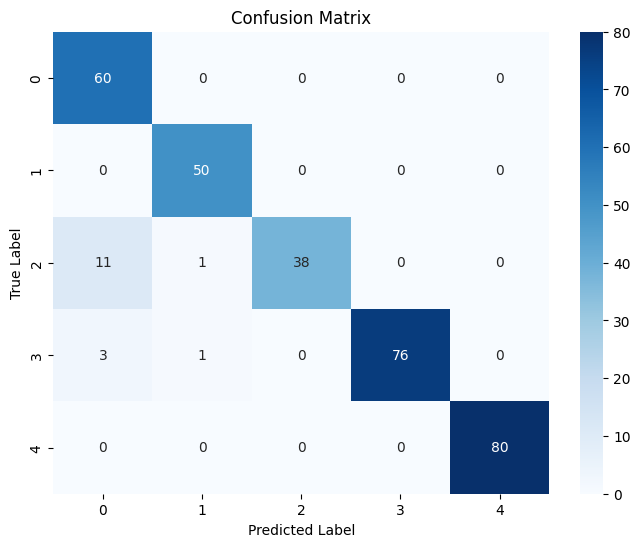

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        60
           1       0.96      1.00      0.98        50
           2       1.00      0.76      0.86        50
           3       1.00      0.95      0.97        80
           4       1.00      1.00      1.00        80

    accuracy                           0.95       320
   macro avg       0.95      0.94      0.94       320
weighted avg       0.96      0.95      0.95       320



In [ ]:
# confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

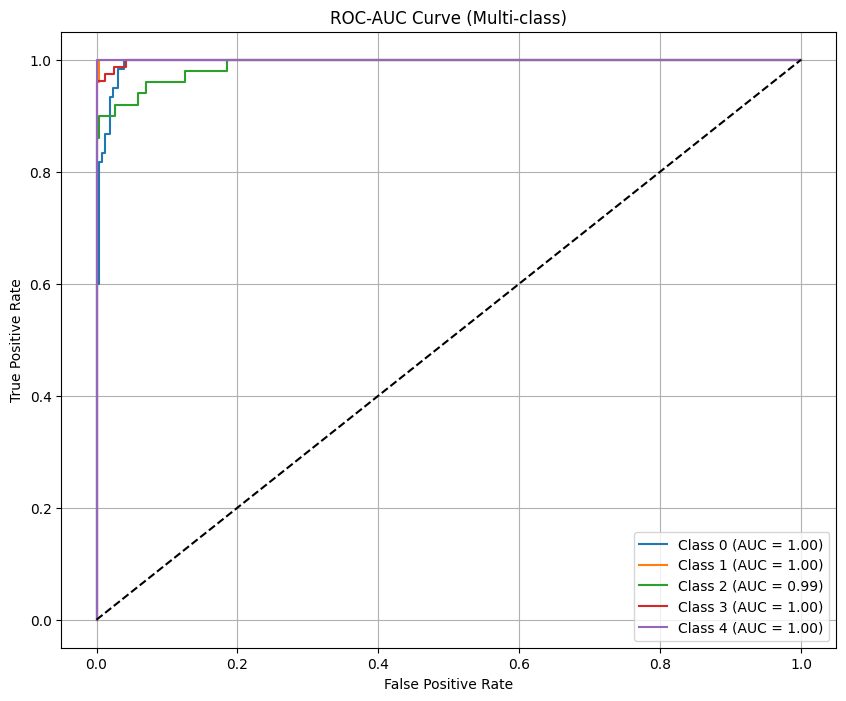

Macro ROC-AUC Score: 0.9969


In [ ]:
# roc-auc
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

n_classes = y_pred_probs.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Computeing ROC AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve (Multi-class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Overall AUC
print(f"Macro ROC-AUC Score: {roc_auc_score(y_true_bin, y_pred_probs, average='macro'):.4f}")

MOBILENETV2

In [97]:
#new model
from tensorflow.keras import backend as K
K.clear_session()

In [98]:
# Defining mobilenet-V2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [105]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import register_keras_serializable
import tensorflow as tf

@register_keras_serializable()
class ChannelMean(Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=-1, keepdims=True)

@register_keras_serializable()
class ChannelMax(Layer):
    def call(self, inputs):
        return tf.reduce_max(inputs, axis=-1, keepdims=True)

class CBAM(tf.keras.layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio
        self.channel_mean = ChannelMean()
        self.channel_max = ChannelMax()
        self.spatial_conv = tf.keras.layers.Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid')

    def build(self, input_shape):
        channel = input_shape[-1]

        # Define shared MLP for channel attention
        self.shared_dense_1 = tf.keras.layers.Dense(channel // self.ratio, activation='relu')
        self.shared_dense_2 = tf.keras.layers.Dense(channel)

    def call(self, inputs):
        # ----- Channel Attention -----
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2])  # shape: (batch, channels)
        max_pool = tf.reduce_max(inputs, axis=[1, 2])  # shape: (batch, channels)

        avg_out = self.shared_dense_2(self.shared_dense_1(avg_pool))
        max_out = self.shared_dense_2(self.shared_dense_1(max_pool))

        channel_attention = tf.nn.sigmoid(avg_out + max_out)
        channel_attention = tf.reshape(channel_attention, [-1, 1, 1, inputs.shape[-1]])
        x = inputs * channel_attention

        # ----- Spatial Attention -----
        avg_pool_spatial = self.channel_mean(x)
        max_pool_spatial = self.channel_max(x)
        concat = tf.concat([avg_pool_spatial, max_pool_spatial], axis=-1)

        spatial_attention = self.spatial_conv(concat)
        refined_feature = x * spatial_attention

        return refined_feature


In [106]:
def build_mobilenet_cbam_model(input_shape=(224, 224, 3), num_classes=5):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # freezing base model

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = CBAM()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

In [107]:
# Clear session before building
from tensorflow.keras import backend as K

mobilenet_cbam_model = build_mobilenet_cbam_model()

# Clear session after building but before compilation
K.clear_session()

mobilenet_cbam_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_cbam_callbacks = [
    callbacks.ModelCheckpoint(
        filepath='mobilenet_cbam_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
]

history_cbam = mobilenet_cbam_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=mobilenet_cbam_callbacks
)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.2733 - loss: 1.6549
Epoch 1: val_accuracy improved from -inf to 0.37267, saving model to mobilenet_cbam_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.2745 - loss: 1.6531 - val_accuracy: 0.3727 - val_loss: 1.5019
Epoch 2/20
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3765 - loss: 1.4434
Epoch 2: val_accuracy did not improve from 0.37267
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.3788 - loss: 1.4409 - val_accuracy: 0.3540 - val_loss: 1.4345
Epoch 3/20
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4962 - loss: 1.2946
Epoch 3: val_accuracy did not improve from 0.37267
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4971 - loss: 1.2930 - val_accuracy: 0.3727 - val_loss: 1.3841
Epoch 4/20
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5353 - loss: 1.1866
Epoch 4: val_accuracy improved from 0.37267 to 0.39130, saving model to mobilenet_cbam_model.keras
36/36 ━━━━━━━━

In [108]:
# Unfreeze the base model
model.get_layer('mobilenetv2_1.00_224').trainable = True

In [109]:

# Recompile with lower learning rate
model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning callbacks
fine_tune_callbacks = [
    callbacks.ModelCheckpoint('mobilenet_cbam_finetuned.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]

# Fine-tune for additional epochs
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=fine_tune_callbacks
)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.2484 - loss: 3.6375
Epoch 1: val_accuracy improved from -inf to 0.41615, saving model to mobilenet_cbam_finetuned.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 84s 923ms/step - accuracy: 0.2496 - loss: 3.6267 - val_accuracy: 0.4161 - val_loss: 2.2304 - learning_rate: 1.0000e-05
Epoch 2/20
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5171 - loss: 1.6067
Epoch 2: val_accuracy improved from 0.41615 to 0.46584, saving model to mobilenet_cbam_finetuned.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.5182 - loss: 1.6033 - val_accuracy: 0.4658 - val_loss: 2.2384 - learning_rate: 1.0000e-05
Epoch 3/20
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7001 - loss: 0.8811
Epoch 3: val_accuracy improved from 0.46584 to 0.53416, saving model to mobilenet_cbam_finetuned.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.7005 - loss: 0.8794 - val_accuracy: 0.5342 - val_loss: 2.2255 - learning_rate: 1.0000e-05


In [110]:
model.save("mobilenet_cbam_final.keras")

EVALUATION OF MOBILENET-V2

In [ ]:
# import os

# # List all files in the current directory
# print(os.listdir())

['.config', 'nasnet_model.keras', 'drive', 'Original_Dataset', 'split_dataset', 'mobilenetv2_wheat.keras', 'nasnet_cbam_model.keras', 'sample_data']


In [ ]:
from tensorflow.keras.models import load_model

# Loading the best model from training
model_cbam_loaded = load_model('mobilenet_cbam_model.keras', custom_objects={'CBAM': CBAM})

In [111]:
from tensorflow.keras.models import load_model

model = load_model(
    "mobilenet_cbam_final.keras",
    custom_objects={
        "CBAM": CBAM,
        "ChannelMean": ChannelMean,
        "ChannelMax": ChannelMax
    }
)

In [112]:
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Loss: {loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.6462 - loss: 1.1766
Test Accuracy: 0.6594
Test Loss: 1.1161


In [117]:
import numpy as np

y_true = []
y_pred = []
y_prob = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())
    y_prob.extend(preds)  # raw probabilities

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


In [119]:
from sklearn.metrics import classification_report
class_names = ['BlackPoint', 'WhearBlast', 'LeafBlight', 'FusariumFootRot', 'HealthyLeaf']

print(classification_report(y_true, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

     BlackPoint       0.51      0.98      0.67        60
     WhearBlast       0.88      0.44      0.59        50
     LeafBlight       1.00      0.04      0.08        50
FusariumFootRot       0.63      0.82      0.71        80
    HealthyLeaf       0.85      0.78      0.81        80

       accuracy                           0.66       320
      macro avg       0.77      0.61      0.57       320
   weighted avg       0.76      0.66      0.61       320



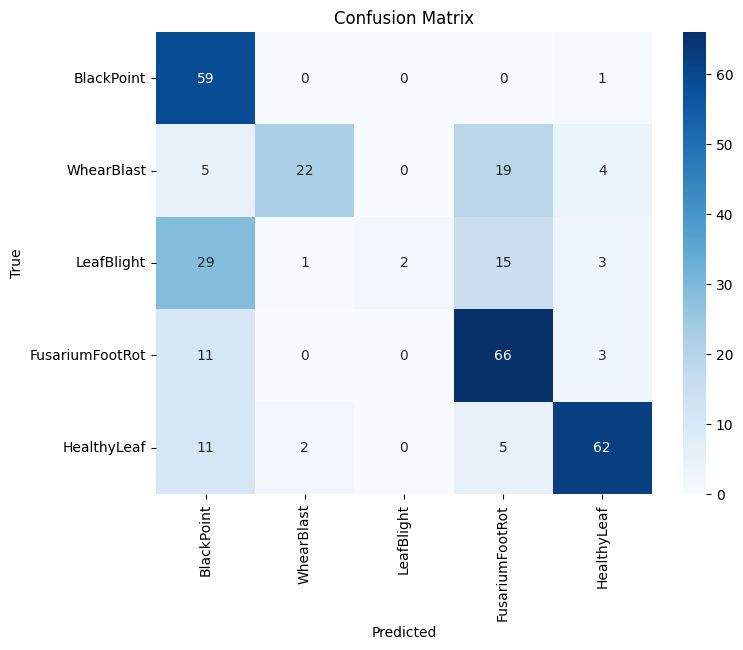

In [120]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

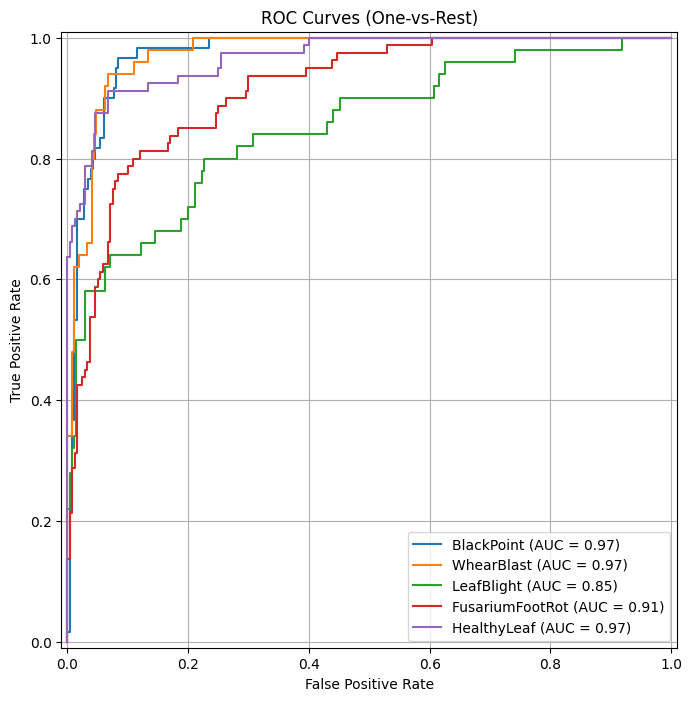

In [122]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# Binarize true labels for multi-class ROC AUC
num_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_prob = np.array(y_prob)

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=class_names[i]).plot(ax=plt.gca())

plt.title('ROC Curves (One-vs-Rest)')
plt.grid(True)
plt.show()

CUSTOM CNN

In [ ]:
#new model
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
# CNN model
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=5):
    model3 = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model3

In [ ]:
# compile and train CNN model
cnn_model = build_custom_cnn()
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_cnn = cnn_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.1985 - loss: 232.3097 - val_accuracy: 0.3540 - val_loss: 1.5925
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3045 - loss: 1.5204 - val_accuracy: 0.2236 - val_loss: 1.9353
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.3354 - loss: 1.5173 - val_accuracy: 0.3602 - val_loss: 1.5007
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.3647 - loss: 1.4796 - val_accuracy: 0.3043 - val_loss: 1.5678
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4277 - loss: 1.3546 - val_accuracy: 0.2981 - val_loss: 1.5600
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4940 - loss: 1.2221 - val_accuracy: 0.2981 - val_loss: 1.5625
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5262 - loss: 1.1251 - val_accuracy: 0.2733 - val_loss: 1.8679
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5352 - loss: 1.1408 - val_accuracy: 0.2733 - val_loss

In [ ]:
cnn_model.save("custom_cnn_model.keras")

In [ ]:
from tensorflow.keras.models import load_model
cnn_model = load_model("custom_cnn_model.keras")

In [ ]:
test_loss, test_acc = cnn_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3633 - loss: 1.8234
Test Accuracy: 0.3375
Test Loss: 1.8766


In [ ]:
import numpy as np

# to get true labels and predicted probabilities
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = cnn_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_true, axis=1)  # converting one-hot to label


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        60
           1       0.25      0.34      0.29        50
           2       1.00      0.02      0.04        50
           3       0.33      0.69      0.44        80
           4       0.40      0.41      0.41        80

    accuracy                           0.34       320
   macro avg       0.60      0.30      0.25       320
weighted avg       0.57      0.34      0.28       320



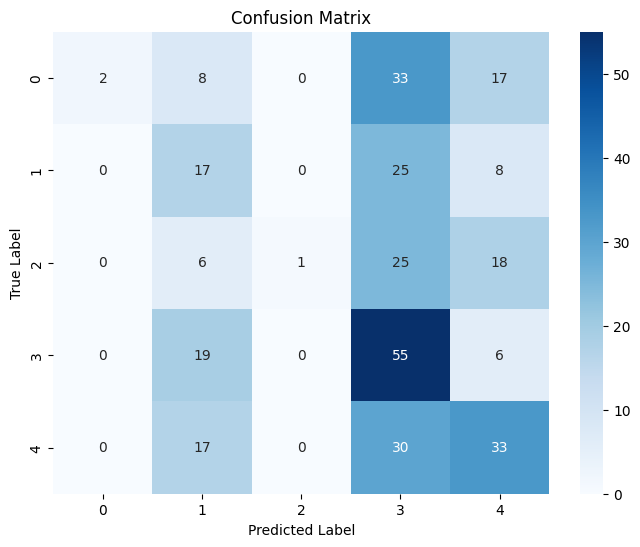

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

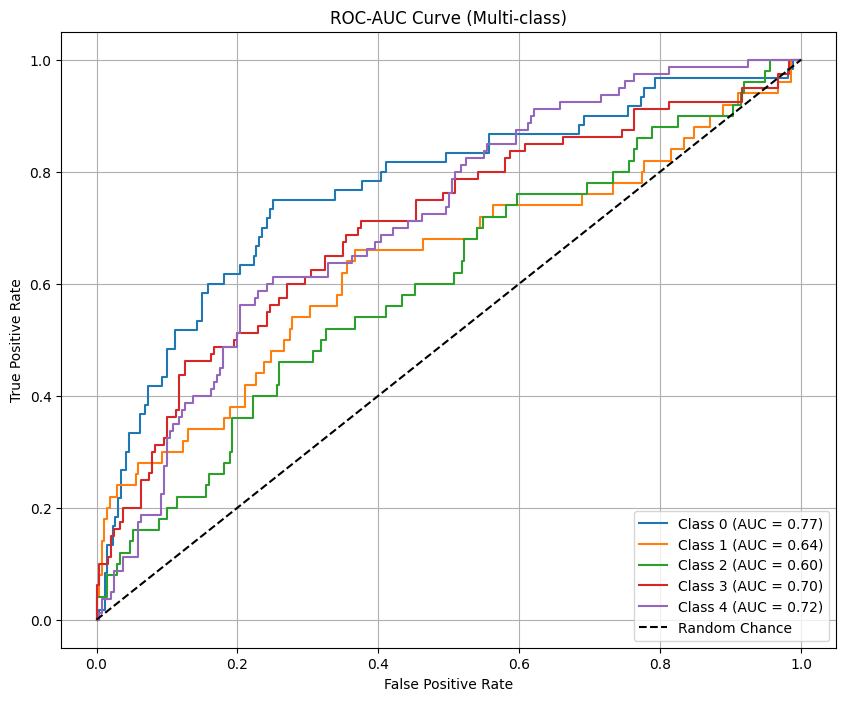

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize true labels for multi-class ROC
n_classes = len(np.unique(y_true))
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Calculate FPR, TPR, AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve (Multi-class)")
plt.legend(loc='lower right')
plt.grid()
plt.show()

NASNetMobile

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import register_keras_serializable

In [ ]:
# CBAM MODULE
@register_keras_serializable()
class CBAM(tf.keras.layers.Layer):
    def __init__(self, filters, reduction_ratio=8, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.filters = filters
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.shared_mlp = tf.keras.Sequential([
            layers.Dense(self.filters // self.reduction_ratio, activation='relu'),
            layers.Dense(self.filters)
        ])
        self.conv_spatial = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, input_tensor):
        # Channel attention
        avg_pool = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(input_tensor, axis=[1, 2], keepdims=True)
        channel_attention = tf.nn.sigmoid(
            self.shared_mlp(avg_pool) + self.shared_mlp(max_pool)
        )
        x = input_tensor * channel_attention

        # Spatial attention
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        spatial_attention = self.conv_spatial(concat)
        x = x * spatial_attention
        return x

In [ ]:
# MODEL BUILD FUNCTIONAL
def build_nasnet_cbam(input_shape=(224, 224, 3), num_classes=5):
    inputs = tf.keras.Input(shape=input_shape)
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_tensor=inputs)
    base_model.trainable = False  # freeze NASNet

    x = base_model.output
    x = CBAM(filters=x.shape[-1])(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model, base_model

In [ ]:
# BUILD MODEL
model_cbam, base_model = build_nasnet_cbam()

In [ ]:
# COMPILE
model_cbam.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# CALLBACKS
cbam_callbacks = [
    callbacks.ModelCheckpoint('nasnet_cbam_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
]

In [ ]:
# ---- TRAIN ---- #
history_cbam = model_cbam.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=cbam_callbacks
)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.1964 - loss: 2.8347
Epoch 1: val_accuracy improved from -inf to 0.15528, saving model to nasnet_cbam_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.1967 - loss: 2.8341 - val_accuracy: 0.1553 - val_loss: 2.2362
Epoch 2/20
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1776 - loss: 2.8426
Epoch 2: val_accuracy did not improve from 0.15528
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.1790 - loss: 2.8357 - val_accuracy: 0.1553 - val_loss: 2.1695
Epoch 3/20
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1901 - loss: 2.6541
Epoch 3: val_accuracy improved from 0.15528 to 0.18634, saving model to nasnet_cbam_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.1906 - loss: 2.6546 - val_accuracy: 0.1863 - val_loss: 2.0989
Epoch 4/20
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2163 - loss: 2.4558
Epoch 4: val_accuracy improved from 0.18634 to 0.20497, saving model to

In [ ]:
# Unfreezing the top NASNet layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Unfreezing last 20 layers
    layer.trainable = False

# Recompiling with lower learning rate for fine-tuning
model_cbam.compile(
    optimizer=optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model_cbam.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbam_callbacks
)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.2573 - loss: 2.0183
Epoch 1: val_accuracy improved from 0.21739 to 0.24845, saving model to nasnet_cbam_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.2570 - loss: 2.0192 - val_accuracy: 0.2484 - val_loss: 1.6410
Epoch 2/10
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2519 - loss: 1.9983
Epoch 2: val_accuracy did not improve from 0.24845
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.2517 - loss: 2.0001 - val_accuracy: 0.2360 - val_loss: 1.6472
Epoch 3/10
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2345 - loss: 2.0064
Epoch 3: val_accuracy did not improve from 0.24845
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.2351 - loss: 2.0077 - val_accuracy: 0.2298 - val_loss: 1.6531
Epoch 4/10
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2426 - loss: 2.0723
Epoch 4: val_accuracy did not improve from 0.24845
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.2426 - lo

In [ ]:
# from tensorflow.keras.applications import NASNetMobile
# from tensorflow.keras import layers, models, optimizers, callbacks

# def build_nasnet_model(input_shape=(224, 224, 3), num_classes=5):
#     base_model4 = NASNetMobile(weights='imagenet', include_top=False, input_shape=input_shape)
#     base_model4.trainable = False  # freeze base for feature extraction

#     model4 = models.Sequential([
#         base_model4,
#         layers.GlobalAveragePooling2D(),
#         layers.Dense(128, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes, activation='softmax')
#     ])
#     return model4, base_model4

# # Build the model
# nasnet_model, base_nasnet = build_nasnet_model()

# # Compile with learning rate
# nasnet_model.compile(
#     optimizer=optimizers.Adam(learning_rate=1e-5),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Define callbacks
# nasnet_callbacks = [
#     callbacks.ModelCheckpoint(
#         filepath='nasnet_model.keras',
#         monitor='val_accuracy',
#         save_best_only=True,
#         verbose=1
#     ),
#     callbacks.EarlyStopping(
#         monitor='val_loss',
#         patience=3,
#         restore_best_weights=True,
#         verbose=1
#     )
# ]

# # Train
# history_nasnet = nasnet_model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=20,
#     callbacks=nasnet_callbacks
# )

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1824 - loss: 10.1114   
Epoch 1: val_accuracy improved from -inf to 0.18634, saving model to nasnet_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.1824 - loss: 10.0946 - val_accuracy: 0.1863 - val_loss: 8.2062
Epoch 2/20
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.1607 - loss: 9.7646
Epoch 2: val_accuracy did not improve from 0.18634
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.1617 - loss: 9.7315 - val_accuracy: 0.1863 - val_loss: 7.6726
Epoch 3/20
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1833 - loss: 8.8865
Epoch 3: val_accuracy did not improve from 0.18634
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.1835 - loss: 8.8756 - val_accuracy: 0.1863 - val_loss: 7.1686
Epoch 4/20
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1865 - loss: 8.4036
Epoch 4: val_accuracy did not improve from 0.18634
36/36 ━━━━━━━━━━━

In [ ]:
# Unfreeze base model
base_nasnet.trainable = True

# Recompile with a lower LR (fine-tuning)
nasnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Slower learning rate!
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train further
fine_tune_history = nasnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # Start with 10 more epochs
    callbacks=nasnet_callbacks  # Same early stopping & checkpoint
)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2337 - loss: 1.7673   
Epoch 1: val_accuracy did not improve from 0.22360
36/36 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - accuracy: 0.2338 - loss: 1.7671 - val_accuracy: 0.2174 - val_loss: 1.7084
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.3450 - loss: 1.4930
Epoch 2: val_accuracy did not improve from 0.22360
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 217ms/step - accuracy: 0.3448 - loss: 1.4938 - val_accuracy: 0.1801 - val_loss: 1.8089
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.4433 - loss: 1.3407
Epoch 3: val_accuracy did not improve from 0.22360
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.4432 - loss: 1.3408 - val_accuracy: 0.1988 - val_loss: 1.7456
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5129 - loss: 1.1985
Epoch 4: val_accuracy did not improve from 0.22360
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.5131 - loss: 1.1984 - val_accuracy: 0.2050 - 